In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
# %matplotlib widget

def calcExcapeMiscount(eDepFileTitle, rootFileTitle, particle, energy, xinit, yinit, drawPlots:bool = False):

    #################################
    ## root file and data frame
    #################################

    tree = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV_{xinit},{yinit}.root")["Eecs"]
    df = tree.arrays(library="np")
 
    treeEdep = uproot.open(f"{rootFileTitle}_{particle}_{energy}GeV_{xinit},{yinit}.root")["Edep"]
    eEscInEvent = treeEdep.arrays(["eDep"], library="np")
    eEscInEvent = energy*1000-eEscInEvent["eDep"]


    number_of_events = np.max(df['evntID'])+1

    escapedEnergy = np.sum(df['escE'])/number_of_events
#     eEscInEvent = np.array([np.sum(df["escE"][df["evntID"] == evID]) for evID in range(number_of_events)])

    #################################
    ## eDep File & eDep mesh
    #################################

    nDivisionsXY = 175
    nDivisionsR = 88
    sLength = 87.5

    fileEdep = open(f"{eDepFileTitle}_{particle}_{energy}GeV_Box_{xinit},{yinit}.txt")

    mesh = np.zeros((nDivisionsXY, nDivisionsXY))

    fileEdep.readline() # skip 3 firts lines
    fileEdep.readline()
    fileEdep.readline()

    for line in fileEdep:
        lineSplit = line.split(",")

        ix = int(lineSplit[0])
        iy = int(lineSplit[1])

        eDep = float(lineSplit[3])

        mesh[ix, iy] += eDep

    mesh/=number_of_events


    if drawPlots:
        #################################
        ## eDep plots
        #################################
        plt.figure(figsize=(6.4, 4.8))

        ## eDep mesh
        plt.imshow(np.transpose(mesh), extent=(-sLength, sLength, -sLength, sLength), norm=colors.LogNorm(vmin=1e-3))
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Deposited Energy [MeV]")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.title(f"Energy deposition of {energy} GeV {particle}")
        ax = plt.gca()
        ax.text(0.05, 0.05, "dx = dy = 1 mm", transform=ax.transAxes, color="white")  


        #################################
        ## E escape plots
        #################################

        plt.figure(figsize=(12.8*1.1, 4.8*1.1))
        grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.5) 


        sideEscapeSelect = np.fabs(df['Zpos']) < 199.9

        ## Z of side escape
        plt.subplot(grid[0, 0])
        plt.hist(df["Zpos"][sideEscapeSelect] + 200, weights=df["escE"][sideEscapeSelect]/number_of_events, bins=100)
        plt.title(f"Histogram of side-escaping energy, {particle} {energy} GeV")
        plt.xlabel("Depth in volume [mm]")
        plt.ylabel("$E_{dep}$ [MeV]")
        ax = plt.gca()
        ax.text(0.05, 0.9, "The bin size is 4 mm.", transform=ax.transAxes) 
        ax.text(0.05, 0.6, "Mean (over events)\nside-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][sideEscapeSelect])/number_of_events), 
                transform=ax.transAxes) 

        ## event wise escaping distribution
        plt.subplot(grid[1, 0])
        plt.hist(eEscInEvent[eEscInEvent < 3.5*np.mean(eEscInEvent)], bins= int( np.sqrt(number_of_events) ))
        plt.title("Event-wise histogram of escaped energy")
        plt.xlabel("Escaped energy [MeV]")
        ax = plt.gca()
        ax.text(0.7, 0.8, "$\mu$ = {:.2f} MeV\nRMS = {:.2f} MeV".format(np.mean(eEscInEvent), np.std(eEscInEvent)), 
                transform=ax.transAxes) 

        ## XY of side escape
        plt.subplot(grid[:, 1])
        plt.hist2d(df["Xpos"][sideEscapeSelect], df["Ypos"][sideEscapeSelect], 
                weights=df["escE"][sideEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Side-escaped energy [MeV]")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.title("Histogram of side-escaping energy")
        ax = plt.gca()
        ax.text(0.3, 0.1, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes)  

        plt.savefig(f"plots/Side_energy_escaping_of_{energy}_GeV_{particle}.png")


        #################################
        ## Top bottom escape plots
        #################################
        fig = plt.figure(figsize=(12.8, 4.8))
        plt.subplots_adjust(wspace=0.31)

        ## top escape hist
        plt.subplot(1,2,1)
        topEscapeSelect = df['Zpos'] < -199.99
        plt.hist2d(df["Xpos"][topEscapeSelect], df["Ypos"][topEscapeSelect], 
                weights=df["escE"][topEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Top-escaped energy [MeV]")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.title(f"Top-escaping energy, {particle} {energy} GeV")
        ax = plt.gca()
        ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes, color="white")
        ax.text(0.05, 0.01, 
                "Mean (over events)\ntop-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][topEscapeSelect])/number_of_events),
                transform=ax.transAxes, color="white")

        ## top escape hist
        plt.subplot(1,2,2)
        botEscapeSelect = df['Zpos'] > 199.99
        plt.hist2d(df["Xpos"][botEscapeSelect], df["Ypos"][botEscapeSelect], 
                weights=df["escE"][botEscapeSelect]/number_of_events, bins=15, norm=colors.LogNorm(vmin=0.05))
        cbar = plt.colorbar()
        cbar.ax.set_ylabel("Bottom-escaped energy [MeV]")
        plt.xlabel("x [mm]")
        plt.ylabel("y [mm]")
        plt.title("Bottom-escaping energy")
        ax = plt.gca()
        ax.text(0.55, 0.01, "dx = dy = {:.2f} mm".format(sLength*2/15), transform=ax.transAxes, color="white")
        ax.text(0.05, 0.01, 
                "Mean (over events)\nbottom-escaped energy\nis {:.2f} MeV".format(np.sum(df["escE"][botEscapeSelect])/number_of_events),
                transform=ax.transAxes, color="white")


    meansEscapeEnergy = np.mean(eEscInEvent)
    rmsEscapeEnergy = np.std(eEscInEvent)

    return (meansEscapeEnergy, rmsEscapeEnergy)

In [2]:
dist = [0, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84]

escapeE  =  []
rmsEscE  =  []

print("Escaped enery \trms of escped")

for x in dist:
    escapeE_tmp, rmsEscE_tmp = calcExcapeMiscount("build/eDep","build/eEsc", "gamma", 25, x, 0)

    print("{:.4f}\t\t{:.4f}".format(escapeE_tmp/1000, rmsEscE_tmp/1000))

    escapeE.append(escapeE_tmp/1000)
    rmsEscE.append(rmsEscE_tmp/1000)

Escaped enery 	rms of escped
0.6455		0.1941
0.6472		0.1844
0.6639		0.1710
0.6906		0.1722
0.7306		0.1470
0.7999		0.2181
0.8950		0.1661
1.0318		0.1599
1.2417		0.1783
1.5489		0.1778
2.0896		0.1751
3.2291		0.2583
6.9333		0.5201


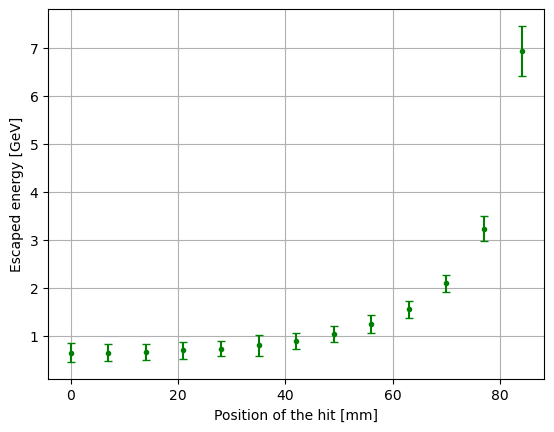

In [3]:
plt.figure()
plt.errorbar(dist, escapeE, yerr=rmsEscE, fmt='.g', capsize=3)
# plt.errorbar(dist, escapeE, yerr=misscount, fmt='.r', capsize=3, markersize=0)
# plt.plot(dist, escapeE, '.g')
plt.ylabel("Escaped energy [GeV]")
plt.xlabel("Position of the hit [mm]")
plt.grid()

(1548.8898, 177.84256)

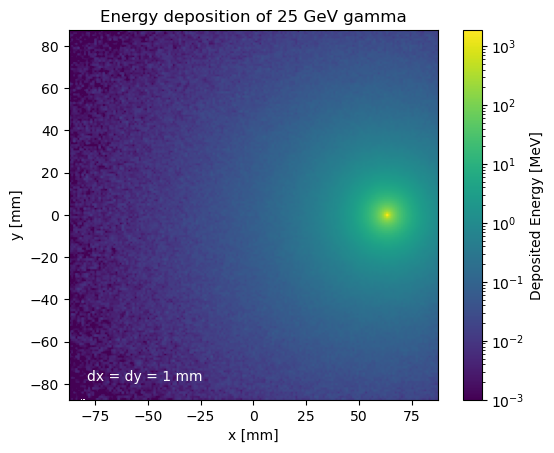

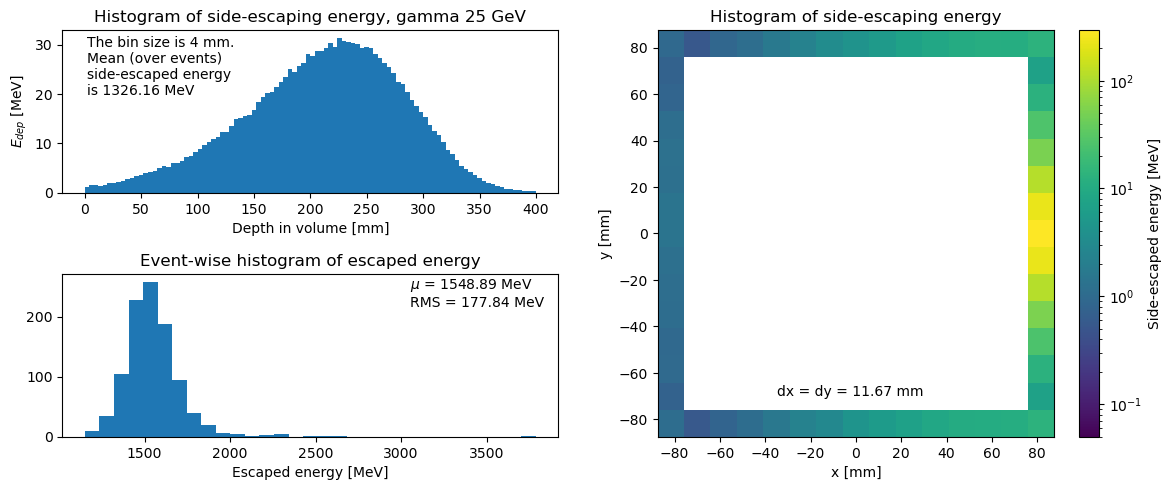

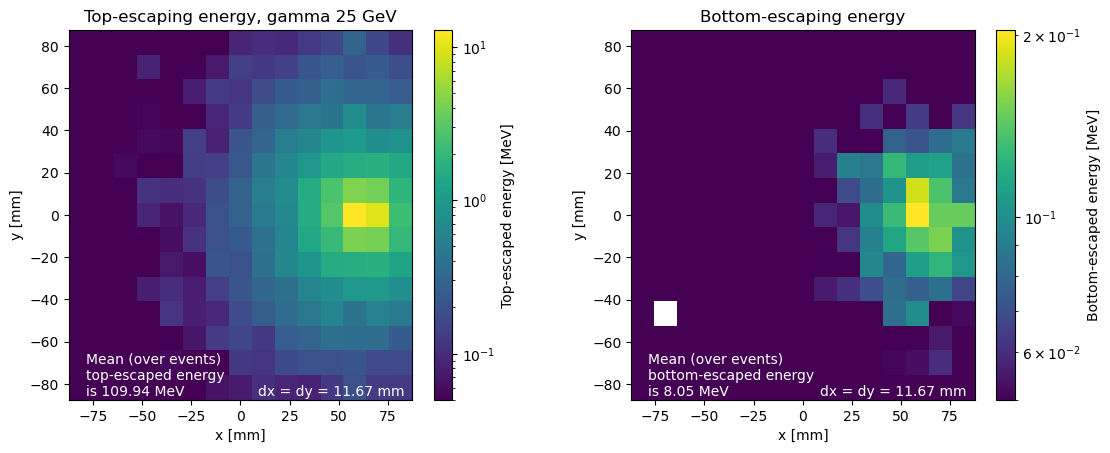

In [6]:
calcExcapeMiscount("build/eDep","build/eEsc", "gamma", 25, 63, 0, True)